<a href="https://colab.research.google.com/github/irene880104/datasharing/blob/master/Marketing_HW1_Irene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

Load Library

In [1]:
# load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings("ignore")


Read in the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_trans = '/content/drive/MyDrive/Colab Notebooks/transaction_data.csv'
transaction = pd.read_csv(path_trans)
print(transaction.head(),transaction.shape)

   Customer ID  Order Date  Profit
0            1  2019-02-24   27.94
1            2  2019-02-11  196.33
2            2  2019-02-13   79.19
3            2  2019-02-21  255.27
4            2  2019-04-14  126.26 (29659, 3)


In [4]:
path_cust = '/content/drive/MyDrive/Colab Notebooks/cust_data.csv'
cust = pd.read_csv(path_cust)
print(cust.head(), cust.shape)

   Customer ID State Treatment Group
0            0    VA         No Mail
1            1    VA            Mail
2            2    VA            Mail
3            3    OH            Mail
4            4    OH            Mail (12000, 3)


# Homework

# 1- Data Processing

**1.Before the analysis, you need to preprocess the data.**

a. Calculate the pre-treatment variable “Profit 60 days before the treatment date” for each customer in the experiment

b. Calculate the outcome “Profit 60 days a.er the treatment date” for each customer in the experiment

c. For each of these two variables report the mean and standard devia9on.


---
The experiment started on early morning 2nd March 2019 '2019-03-02'
60 days before:




In [5]:
from datetime import datetime, timedelta

# Given date
mail_date = datetime(2019, 3, 2)

# Calculate the date 60 days before
start_before_60 = mail_date - timedelta(days=60)
start_after_60 = mail_date + timedelta(days=60)
print("60 days before the given date:", start_before_60)
print("60 days after the given date:", start_after_60)

60 days before the given date: 2019-01-01 00:00:00
60 days after the given date: 2019-05-01 00:00:00


In [6]:
# Create a copy of the DataFrame
treatment = transaction.copy()

# Define the conditions for 'Before treatment' and 'After treatment'
before_condition = (transaction['Order Date'] < '2019-03-02') & (transaction['Order Date']>= start_before_60.strftime('%Y-%m-%d'))
after_condition = (transaction['Order Date'] >= '2019-03-02') & (transaction['Order Date']<= start_after_60.strftime('%Y-%m-%d'))

#before_condition = treatment['Order Date'] == start_before_60.strftime('%Y-%m-%d')
#after_condition = treatment['Order Date'] == start_after_60.strftime('%Y-%m-%d')


# Create 'Time' column based on conditions
treatment['Time'] = np.where(before_condition, 'before_treatment', np.where(after_condition, 'after_treatment', 'Unknown'))

# Display the result
print(treatment)


       Customer ID  Order Date  Profit              Time
0                1  2019-02-24   27.94  before_treatment
1                2  2019-02-11  196.33  before_treatment
2                2  2019-02-13   79.19  before_treatment
3                2  2019-02-21  255.27  before_treatment
4                2  2019-04-14  126.26   after_treatment
...            ...         ...     ...               ...
29654        11998  2019-02-18    6.92  before_treatment
29655        11998  2019-03-24    6.98   after_treatment
29656        11998  2019-04-14   10.98   after_treatment
29657        11998  2019-04-17   17.25   after_treatment
29658        11999  2019-02-14  165.04  before_treatment

[29659 rows x 4 columns]


In [7]:
pivot = treatment.pivot_table(index='Customer ID', columns='Time', values='Profit', aggfunc='sum')
pivot = pd.merge(pivot,cust, on= 'Customer ID', how = 'right').fillna(0)
pivot

,Customer ID,after_treatment,before_treatment,State,Treatment Group
0,0,0.00,0.00,VA,No Mail
1,1,0.00,27.94,VA,Mail
2,2,126.26,530.79,VA,Mail
3,3,0.00,0.00,OH,Mail
4,4,99.91,54.72,OH,Mail
...,...,...,...,...,...
11995,11995,115.05,0.00,GA,No Mail
11996,11996,68.42,146.98,GA,No Mail
11997,11997,0.00,0.00,OH,Mail
11998,11998,35.21,6.92,OH,Mail


In [8]:

print('before: ', pivot['before_treatment'].mean(), pivot['before_treatment'].std())
print('after: ', pivot['after_treatment'].mean(), pivot['after_treatment'].std())

before:  77.33159666666667 229.00680235958325
after:  119.34988583333335 337.11882000569


In [9]:
print(pivot['before_treatment'].describe(), pivot['after_treatment'].describe())

count    12000.000000
mean        77.331597
std        229.006802
min          0.000000
25%          0.000000
50%          5.560000
75%         65.220000
max       7372.070000
Name: before_treatment, dtype: float64 count    12000.000000
mean       119.349886
std        337.118820
min          0.000000
25%          0.000000
50%         14.545000
75%        103.285000
max       9649.510000
Name: after_treatment, dtype: float64


In [10]:
pivot[(pivot['after_treatment']+pivot['before_treatment']) == 0].groupby('Treatment Group').count()

,Customer ID,after_treatment,before_treatment,State
Treatment Group,,,,
Mail,1476,1476,1476,1476
No Mail,1491,1491,1491,1491


# 2- ITT

**2. Before and After.**

Assume you tried to estimate the effect of the campaign without the experiment by using only the treatment group (before and after)

a. What would be your treatment effect of mailing a catalog?

b. Assuming the results are sta9s9cally significant would you launch a full-scale marke9ng campaign based on these results?

c. What is the expected gain of your marke9ng campaign if you launch it on the
remaining popula9on?

Note: Gain here is part of the total profit attributed to the marketing campaign – total profit with sending a catalog minus total profit without sending a catalog

In [11]:
itt_result = pivot.agg({'after_treatment': ['mean', 'std', 'count'], 'before_treatment': ['mean', 'std', 'count']})
itt_result

,after_treatment,before_treatment
mean,119.349886,77.331597
std,337.118820,229.006802
count,12000.000000,12000.000000


In [12]:
# a. What would be your treatment effect of mailing a catalog? (ITT)
itt = itt_result['after_treatment'] - itt_result['before_treatment']
round(itt['mean'],2)

42.02

In [13]:
# p-value calculation
n = itt_result.loc['count','after_treatment']
mean_after = itt_result.loc['mean','after_treatment']
std_after = itt_result.loc['std','after_treatment']
mean_before = itt_result.loc['mean','before_treatment']
std_before = itt_result.loc['std','after_treatment']

# Calculate t-value

t_value = (mean_after - mean_before) / np.sqrt((std_after**2 / n) + (std_before**2 / n))

print(f"T-value: {t_value}")

df = n-1  # Degrees of freedom, assuming n = 12000

# Calculate the one-tailed p-value
one_tailed_p_value = 1 - t.cdf(abs(t_value), df)

print(f"One-tailed p-value: {one_tailed_p_value}")


T-value: 9.65452680309458
One-tailed p-value: 0.0


In [14]:
# b. Assuming the results are statistically significant would you launch a full-scale marketing campaign based on these results?
# Yes, since the cost per catalog is $20 and we will get a 42.02 improvement. (42.02>20) Worth it.

In [15]:
# c. What is the expected gain of your marketing campaign if you launch it on the remaining population?
total_pop = 312000
sample_pop = 12000
itt_pro = (total_pop-sample_pop)*(itt['mean']-20)
round(itt_pro,2)

6605486.75

# 3-Randomization/ State

**3. Randomization check.**

Using the methods discussed in class, check the internal validity of the experiment:

?? a. Check the categorical variable (State). Which test you would use? Report p-value

b. Check the “Profit 60 days before the treatment date”. Which test you would use? Report p-value

*Note: typically, you can’t assume the sign of the difference for the randomization check, so it is better to use a two-sided test.*

c. What is your conclusion, can you proceed to experiment evaluation?

In [16]:
state_result = pivot.groupby(['State','Treatment Group']).size().reset_index()
state_result

,State,Treatment Group,0
0,GA,Mail,2171
1,GA,No Mail,2154
2,OH,Mail,2035
3,OH,No Mail,2067
4,VA,Mail,1794
5,VA,No Mail,1779


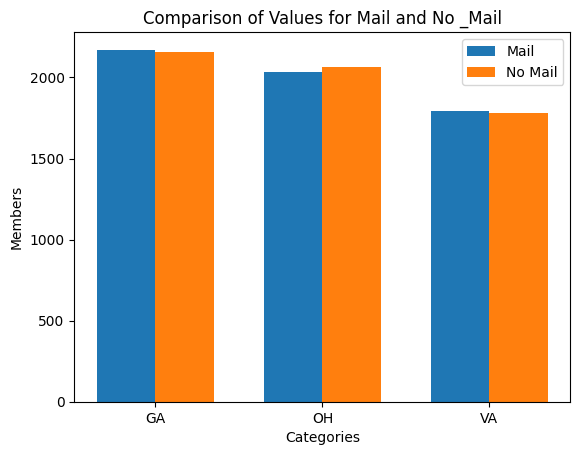

In [17]:
import matplotlib.pyplot as plt

# Sample data
categories = state_result['State'].unique()
treatment = ['Mail', 'No Mail']

# Set the width of the bars
bar_width = 0.35

# Calculate positions for bars
positions_year1 = np.arange(len(categories))
positions_year2 = positions_year1 + bar_width

# Create side-by-side bar plots
plt.bar(positions_year1, state_result[state_result['Treatment Group'] == 'Mail'][0], width=bar_width, label='Mail')
plt.bar(positions_year2, state_result[state_result['Treatment Group'] == 'No Mail'][0], width=bar_width, label='No Mail')

# Labeling and customization
plt.xlabel('Categories')
plt.ylabel('Members')
plt.title('Comparison of Values for Mail and No _Mail')
plt.xticks(positions_year1 + bar_width / 2, categories)
plt.legend()

# Show the plot
plt.show()


# 4- ATE

**4.Average Treatment Effect.**

Using the methods discussed in class compute the results of the experiment for “Profit 60 days a.er the treatment date.

a. Estimate the Average Treatment Effect of sending a catalog

b. Determine if the results are sta9s9cally significant at 5%. Report p-value and standard error

c. Would you launch a full-scale marke9ng campaign based on these results?

d. What is the expected gain of your marke9ng campaign if you launch it on the
remaining popula9on?

e. How would you compare the results with (2)? Explain.

||Before_Profit (Control)|After_Profit (Treatment)|
|:---|:----|:------|
|Mail|75.048617|128.221528|
|No_mail|79.614577|110.478243|


In [18]:
ate_result = pivot.groupby('Treatment Group').agg({'before_treatment': ['mean', 'std', 'count'], 'after_treatment': ['mean','std','count']}).reset_index()
ate_result.columns = ['Treatment Group', 'before_mean', 'before_std', 'before_count',
                      'after_mean', 'after_std', 'after_count']
#ate_result['diff'] = ate_result['after_mean'] - ate_result['before_mean']
ate_result

,Treatment Group,before_mean,before_std,before_count,after_mean,after_std,after_count
0,Mail,75.048617,216.551272,6000,128.221528,377.443008,6000
1,No Mail,79.614577,240.815478,6000,110.478243,291.026596,6000


In [19]:
# a. Estimate the Average Treatment Effect of sending a catalog
ate = ate_result.loc[0, 'after_mean'] - ate_result.loc[0, 'before_mean']
round(ate,2)

53.17

In [20]:
# b. Determine if the results are sta9s9cally significant at 5%. Report p-value and standard error

ate_result_mail = ate_result[ate_result['Treatment Group'] == 'Mail']

n = ate_result_mail['after_count']
mean_after = ate_result_mail['after_mean']
std_after = ate_result_mail['after_std']
mean_before = ate_result_mail['before_mean']
std_before = ate_result_mail['before_std']

# standard error
se = np.sqrt((std_after**2 / n) + (std_before**2 / n))
print(f"SE: {se.loc[0]}")
# Calculate t-value
t_value = (mean_after - mean_before) / se

print(f"T-value: {t_value.loc[0]}")

df = n-1

# Calculate the one-tailed p-value
one_tailed_p_value = 1 - t.cdf(abs(t_value), df)


print(f"One-tailed p-value: {one_tailed_p_value}")


SE: 5.6177943150749945
T-value: 9.465086951293417
One-tailed p-value: [0.]


In [21]:
# c. Would you launch a full-scale marke9ng campaign based on these results? --> Yes

In [23]:
# d. What is the expected gain of your marke9ng campaign if you launch it on the remaining popula9on?
total_pop = 312000
sample_pop = 12000
ate_pro = (total_pop-sample_pop)*(ate-20)
#ate_pro = sample_pop*(ate-20)
round(ate_pro,2)

9951873.5

In [24]:
# e. How would you compare the results with (2)? Explain.
# Since the ATE only includes the part of the sample, it provides a higher effect.
print('Att: ', ate, 'Itt: ', itt)

Att:  53.172911666666664 Itt:  mean      42.018289
std      108.112018
count      0.000000
dtype: float64


# 5- DID

**5. Difference-in-difference.**

You want to use the pre-treatment informa9on to improve the es9mates. You decided to use a difference-in-difference es9mator:

a. Es9mate the treatment effect by using the diff-in-diff method

b. Determine if the results are sta9s9cally significant at 5%. Report p-value and standard error

c. Would you launch a full-scale marke9ng campaign based on these results?

d. What is the expected gain of your marke9ng campaign if you launch it on the
remaining popula9on?

e. How would you compare the results with (4)? Explain.

In [26]:
did_result = ate_result.copy()
did_result

,Treatment Group,before_mean,before_std,before_count,after_mean,after_std,after_count
0,Mail,75.048617,216.551272,6000,128.221528,377.443008,6000
1,No Mail,79.614577,240.815478,6000,110.478243,291.026596,6000


In [27]:
# a. Estimate the treatment effect by using the diff-in-diff method
dif = did_result.loc[0, 'before_mean'] - did_result.loc[1, 'before_mean']
did = did_result.loc[0, 'after_mean'] - did_result.loc[1, 'after_mean'] - dif
print(round(did, 2))

22.31


In [28]:
# b. Determine if the results are sta9s9cally significant at 5%. Report p-value and standard error-> YES
# Standard Error: 4.23, P-value: 0.00

# Extract data for group1 and group2
group1_before = pivot[pivot['Treatment Group'] == 'Mail']['before_treatment'].tolist()
group1_after = pivot[pivot['Treatment Group'] == 'Mail']['after_treatment'].tolist()

group2_before = pivot[pivot['Treatment Group'] == 'No Mail']['before_treatment'].tolist()
group2_after = pivot[pivot['Treatment Group'] == 'No Mail']['after_treatment'].tolist()

# Perform paired samples t-test for group1
t_stat_group1, p_value_group1 = ttest_rel(group1_after, group1_before)

# Perform paired samples t-test for group2
t_stat_group2, p_value_group2 = ttest_rel(group2_after, group2_before)

# Calculate DiD
did_values = (np.array(group1_after) - np.array(group1_before)) - (np.array(group2_after) - np.array(group2_before))

# Perform t-test for DiD
t_stat_did, p_value_did = ttest_rel(did_values, np.zeros_like(did_values))

# Calculate standard error for DiD
se_did = np.std(did_values, ddof=1) / np.sqrt(len(did_values))

print(f"T-value for DiD: {t_stat_did}")
print(f"P-value for DiD: {p_value_did}")
print(f"Standard Error for DiD: {se_did}")


T-value for DiD: 5.27264838358537
P-value for DiD: 1.391737640624372e-07
Standard Error for DiD: 4.2311270118926165


In [29]:
# c. Would you launch a full-scale marke9ng campaign based on these results? -> YES, 22.31> 20 this will have a positive profit

# d. What is the expected gain of your marke9ng campaign if you launch it on the remaining popula9on?

total_pop = 312000
did_pro = (did-20) * total_pop
round(did_pro,2)

720484.44

In [36]:
# e. How would you compare the results with (2)? Explain.
# DID has lower effect compare to ATE due to it also considers all samples, which makes the effect smaller.
print('DID: ', did,'Att: ', ate, 'Itt: ', itt['mean'])
print('Profit \nDID: ', did_pro,'ATE: ', ate_pro, 'ITT: ', itt_pro)

DID:  22.309245000000004 Att:  53.172911666666664 Itt:  42.018289166666676
Profit 
DID:  720484.4400000013 ATE:  9951873.5 ITT:  6605486.750000003


# 6- Targeting



**6. Basic Targe0ng.**

Can you come up with a solu9on to earn money?:

a. You have 3 different states in the data. Compute ATE for each state separately.

b. Would you launch a full-scale marke9ng campaign based on these results in any
of the states?

c. What is the expected gain of your marke9ng campaign if you launch it on the
remaining popula9on but you don’t have to launch it in all states?

*Hint: your random sample is representaVve of the whole populaVon. Can you tell
how many people would be from GA in the remaining 300,000 customers?*


In [31]:
state_result = pivot.groupby(['State','Treatment Group']).agg({'before_treatment': ['mean', 'std', 'count'], 'after_treatment': ['mean','std','count']}).reset_index()
state_result.columns = ['State','Treatment Group', 'before_mean', 'before_std', 'before_count',
                      'after_mean', 'after_std', 'after_count']
state_result['diff'] = state_result['after_mean'] - state_result['before_mean']
state_result

,State,Treatment Group,before_mean,before_std,before_count,after_mean,after_std,after_count,diff
0,GA,Mail,88.855822,233.437299,2171,163.376094,412.334077,2171,74.520272
1,GA,No Mail,94.955014,306.809732,2154,132.215023,363.925850,2154,37.260009
2,OH,Mail,74.639106,211.677060,2035,125.877553,388.118648,2035,51.238447
3,OH,No Mail,79.869173,207.688219,2067,107.707557,252.528719,2067,27.838384
4,VA,Mail,58.804420,199.056149,1794,88.338266,311.297898,1794,29.533846
5,VA,No Mail,60.744677,175.834460,1779,87.378741,224.000425,1779,26.634064


In [32]:
# a. You have 3 different states in the data. Compute ATE for each state separately.
state_result_ate = state_result[state_result['Treatment Group'] == 'Mail']
state_result_ate[['State', 'diff']].rename(columns={'diff': 'ATE'})

,State,ATE
0,GA,74.520272
2,OH,51.238447
4,VA,29.533846


In [33]:
# b. Would you launch a full-scale marketing campaign based on these results in any of the states?
# -> Yes P-value is all are < 5% (Reject H0)

# Calculate p-values for each row
p_values = []
state_result_mail = state_result[state_result['Treatment Group'] == 'Mail']

for index, row in state_result_mail.iterrows():
    before_values = np.random.normal(row['before_mean'], row['before_std'], row['before_count'])
    after_values = np.random.normal(row['after_mean'], row['after_std'], row['after_count'])

    _, p_value = ttest_rel(after_values, before_values)
    p_values.append(p_value)

# Add p-values to the DataFrame
state_result_mail['p_value'] = p_values
state_result_mail['p_value'] = state_result_mail['p_value'].apply(lambda x: format(x, '.10f'))

state_result_mail[['State','p_value']]

,State,p_value
0,GA,0.0000007578
2,OH,0.0000000963
4,VA,0.0004775606


In [34]:
# c. What is the expected gain of your marke9ng campaign if you launch it on the remaining popula9on but you don’t have to launch it in all states?
state_result_ate['profit'] = (state_result_ate['diff']-20) * (state_result_ate['after_count']/sample_pop*total_pop)
state_result_ate[['State', 'profit']]

,State,profit
0,GA,3077451.26
2,OH,1652826.24
4,VA,444696.72


# 7- Compare

**7. Compare results in (2), (4), (5) and (6).**

Write a short recommendation to your manager about the marketing campaign and justify it. (Short: less than 5 sentences)


Ans:

The Average Treatment Effect (ATE), Intent-to-Treat (ITT), and Differences-in-Differences (DID) are statistical methods used in impact evaluation. The ATE represents the average impact of a treatment on the outcome. The ITT includes all individuals assigned to a treatment group, regardless of whether they received the treatment, providing an estimate of the treatment's effect in real-world conditions. DID assesses the causal impact by comparing the changes over time between a treatment group and a control group. In your results, the DID effect on the outcome is 22.31, the ATE is 53.17, and the ITT is 42.02. Additionally, the profit associated with each method shows DID at 720,484.44, ATE at 9,951,873.5, and ITT at 6,605,486.75, indicating the economic implications of the treatment effects.